<a href="https://colab.research.google.com/github/fmuranda/Climate_Science./blob/main/tutorials/W2D1_AnEnsembleofFutures/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_AnEnsembleofFutures/student/W2D1_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_AnEnsembleofFutures/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Quantifying Uncertainty in Projections

**Week 2, Day 1, An Ensemble of Futures**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas, Sam Ditkovsky

**Content reviewers:** Mujeeb Abdulfatai, Nkongho Ayuketang Arreyndip, Jeffrey N. A. Aryee, Younkap Nina Duplex,  Sloane Garelick, Paul Heubel, Zahra Khodakaramimaghsoud, Peter Ohue, Jenna Pearson, Abel Shibu, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Paul Heubel, Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** CMIP, NFDI4Earth

# Tutorial Objectives

*Estimated timing for tutorial:* 40 minutes

In the previous tutorial, we constructed a *multi-model ensemble* using data from a diverse set of five CMIP6 models. We showed that the projections differ between models due to their distinct physics, numerics and discretizations. In this tutorial, we will calculate the uncertainty associated with future climate projections by utilizing this variability across CMIP6 models. We will establish a *likely* range of projections as defined by the IPCC.

By the end of this tutorial, you will be able to
- Apply IPCC confidence levels to climate model data,
- Quantify the uncertainty associated with CMIP6/ScenarioMIP projections.


# Setup

    



In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

!pip install condacolab &> /dev/null
import condacolab
condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
!mamba install "xarray==2024.2.0" xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [1]:
# imports
import intake
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import _parse_metric
from datatree import DataTree

In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W2D1_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

%matplotlib inline

In [4]:
# @title Helper functions

def readin_cmip6_to_datatree(facet_dict):
    # open an intake catalog containing the Pangeo CMIP cloud data
    col = intake.open_esm_datastore(
        "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    )

    # from the full `col` object, create a subset using facet search
    cat = col.search(
        source_id=facet_dict['source_id'],
        variable_id=facet_dict['variable_id'],
        member_id=facet_dict['member_id'],
        table_id=facet_dict['table_id'],
        grid_label=facet_dict['grid_label'],
        experiment_id=facet_dict['experiment_id'],
        require_all_on=facet_dict['require_all_on']  # make sure that we only get models which have all of the above experiments
    )

    # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
    kwargs = dict(
        preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
        xarray_open_kwargs=dict(
            use_cftime=True
        ),  # ensure all datasets use the same time index
        storage_options={
            "token": "anon"
        },  # anonymous/public authentication to google cloud storage
    )

    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt


def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ["historical", "ssp126"]:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim="time")

In [5]:
# @title Video 1: Quantifying Uncertainty in Projections

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'IdFRDwzKlsg'), ('Bilibili', 'BV1ocGDetEti')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Quantifying_Uncertainty_in_Projections_Video")

In [7]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "dhx9a"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/dhx9a/


In [8]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Quantifying_Uncertainty_in_Projections_Slides")

# Section 1: Loading CMIP6 Data from Various Models & Experiments

First, lets load the datasets that we used in the previous tutorial, which spanned 5 models. We will use three CMIP6 experiments, adding the high-emissions (*SSP5-8.5*) future scenario to the *historical* and *SSP1-2.6* experiments used in the last tutorial.



In [9]:
# selected CMIP6 models to explore
source_ids = ["IPSL-CM6A-LR", "GFDL-ESM4", "ACCESS-CM2", "MPI-ESM1-2-LR", "TaiESM1"]

# dictionary of facets for query of surface temperature data
facet_dict = { "source_id":source_ids,
    "variable_id":"tos",
    "member_id":"r1i1p1f1",
    "table_id":"Omon",
    "grid_label":"gn",
    "experiment_id":["historical", "ssp126", "ssp585"],
    "require_all_on":"source_id"
    }

# dictionary for query of cell area metric
facet_dict_area = { "source_id":source_ids,
    "variable_id":"areacello",
    "member_id":"r1i1p1f1",
    "table_id":"Ofx",
    "grid_label":"gn",
    "experiment_id":"historical",
    "require_all_on":"source_id"
    }
# search for temperature and area data and return datatree objects
dt_ensemble = readin_cmip6_to_datatree(facet_dict)
dt_area = readin_cmip6_to_datatree(facet_dict_area)


# merge area metric into datatree object
dt_with_area = DataTree()

for model, subtree in dt_ensemble.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ["historical", "ssp126", "ssp585"]:
    da = dt_gm["TaiESM1"][experiment].ds.tos

dt_gm_anomaly = datatree_anomaly(dt_gm)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/usr/local/lib/python3.11/site-packages/xarray/core/indexes.py:469: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)
/usr/local/lib/python3.11/site-packages/xarray/core/indexes.py:469: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)
/usr/local/lib/python3.11/site-packages/xarray/core/indexes.py:469: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/usr/local/lib/python3.11/site-packages/xarray/core/indexes.py:469: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


# Section 2: Quantifying Uncertainty in a CMIP6 Multi-model Ensemble

Let's create a multi-model ensemble containing data from multiple CMIP6 models, which we can use to quantify our confidence in future projected sea surface temperature change under low- and high-emissions scenarios.

**Your goal in this tutorial is to create a *likely* range of future projected conditions under both SSP 1-2.6 (low emissions) and SSP 5-8.5 (high emissions). The [IPCC uncertainty language](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-1/#h3-9-siblings) defines the *likely* range as the middle 66% of model results (ignoring the upper 17% and lower 17% of results)**

### Coding Exercise 2.1

Complete the following code to display multi-model ensemble data with IPCC uncertainty bands:

1. Compute the multi-model mean temperature
2. Display the *likely* range of temperatures for the CMIP6 historical and projected data (include both *SSP1-2.6* and *SSP5-8.5*) via shaded areas with *da_upper* and *da_lower* being the boundaries of these shaded regions.

In [ ]:
#################################################
## TODO for students: Plot range of global mean SST anomaly for five-member ensemble##
# please remove the following line of code once you have completed the exercise:
raise NotImplementedError("Student exercise: Plot range of global mean SST anomaly for five-member ensemble")
#################################################

fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        # calculate annual mean
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp126
    # concatenate all along source_id dimension
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    # compute ensemble mean and draw time series
    da.mean(...).plot(color=color, label=experiment, ax=ax)
    # extract time coordinates
    x = da.time.data
    # Calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(...)
    # Calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(...)
    # shade via quantile boundaries
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)

# aesthetics
ax.set_title(
    "Global Mean SST Anomaly from five-member CMIP6 ensemble\n(base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly (°C)")
ax.set_xlabel("Time (years)")
ax.legend()

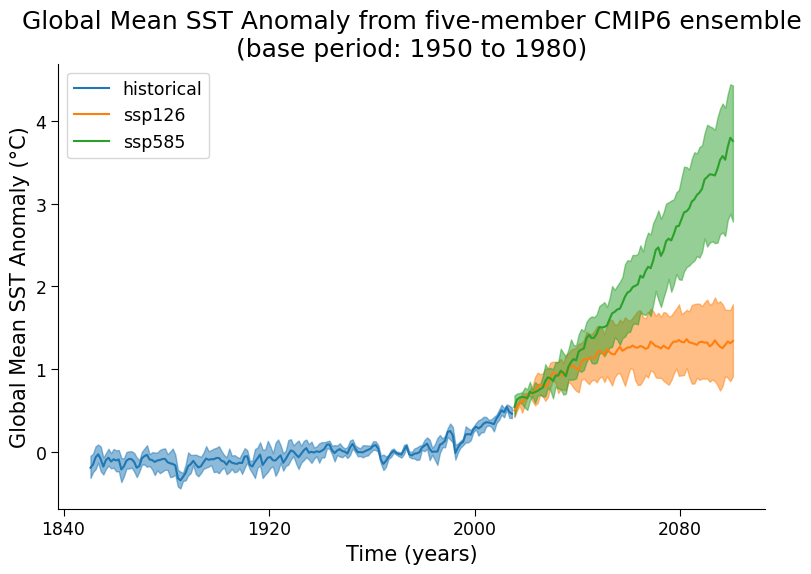

In [11]:
fig, ax = plt.subplots()
for experiment, color in zip(["historical", "ssp126", "ssp585"], ["C0", "C1", "C2"]):
    datasets = []
    for model in dt_gm_anomaly.keys():
        # calculate annual mean
        annual_sst = (
            dt_gm_anomaly[model][experiment]
            .ds.tos.coarsen(time=12)
            .mean()
            .assign_coords(source_id=model)
        )
        datasets.append(
            annual_sst.sel(time=slice(None, "2100")).load()
        )  # the french model has a long running member for ssp126
    # concatenate all along source_id dimension
    da = xr.concat(datasets, dim="source_id", join="override").squeeze()
    # compute ensemble mean and draw time series
    da.mean("source_id").plot(color=color, label=experiment, ax=ax)
    # extract time coordinates
    x = da.time.data
    # Calculate the lower bound of the likely range
    da_lower = da.squeeze().quantile(0.17, dim="source_id")
    # Calculate the upper bound of the likely range
    da_upper = da.squeeze().quantile(0.83, dim="source_id")
    # shade via quantile boundaries
    ax.fill_between(x, da_lower, da_upper, alpha=0.5, color=color)

# aesthetics
ax.set_title(
    "Global Mean SST Anomaly from five-member CMIP6 ensemble\n(base period: 1950 to 1980)"
)
ax.set_ylabel("Global Mean SST Anomaly (°C)")
ax.set_xlabel("Time (years)")
ax.legend()

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D1_AnEnsembleofFutures/solutions/W2D1_Tutorial3_Solution_3cfa2928.py)

*Example output:*

<img alt='Solution hint' align='left' width=811.0 height=574.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_AnEnsembleofFutures/static/W2D1_Tutorial3_Solution_3cfa2928_1.png>



In [13]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_2_1")

### Questions 2.1: Climate Connection

1.   What does this figure tell you about how the multi-model uncertainty compares to projected physical changes in the global mean SST?
2.   Is this the same for both scenarios?
3.   For a 5-model ensemble like this, how do the *likely* ranges specifically relate to the 5 individual model temperatures at a given time?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D1_AnEnsembleofFutures/solutions/W2D1_Tutorial3_Solution_d9195b4a.py)



In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Questions_2_1")

# Summary
In this tutorial, we have quantified the uncertainty of future climate projections by analyzing variability across a multi-model CMIP6 ensemble. We learned to apply the IPCC's confidence levels to establish a *likely* range of projections, which refers to the middle 66% of model results, for multiple emission pathways.

# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble.

For a detailed explanation of the ***IPCC uncertainty language*** have a look at [Box 1.1, Chapter 1 of the IPCC AR6, cf. p. 169-170](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-1/#h3-9-siblings).

For examples of how to access and analyze CMIP6 data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html).

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).